In [2]:
from datasets import load_dataset
from datasets import concatenate_datasets, DatasetDict
import evaluate
import nltk
from nltk.tokenize import sent_tokenize
from transformers import AutoModelForSeq2SeqLM
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
english_dataset = load_dataset("amazon_reviews_multi", "en")
english_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /Users/niclascramer/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})

In [5]:
rouge_score = evaluate.load("rouge")

In [6]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        print(f"\n'>> Title: {example['review_title']}'")
        print(f"'>> Review: {example['review_body']}'")


show_samples(english_dataset)


'>> Title: Worked in front position, not rear'
'>> Review: 3 stars because these are not rear brakes as stated in the item description. At least the mount adapter only worked on the front fork of the bike that I got it for.'

'>> Title: meh'
'>> Review: Does it’s job and it’s gorgeous but mine is falling apart, I had to basically put it together again with hot glue'

'>> Title: Can't beat these for the money'
'>> Review: Bought this for handling miscellaneous aircraft parts and hanger "stuff" that I needed to organize; it really fit the bill. The unit arrived quickly, was well packaged and arrived intact (always a good sign). There are five wall mounts-- three on the top and two on the bottom. I wanted to mount it on the wall, so all I had to do was to remove the top two layers of plastic drawers, as well as the bottom corner drawers, place it when I wanted and mark it; I then used some of the new plastic screw in wall anchors (the 50 pound variety) and it easily mounted to the wall. 

In [8]:
english_dataset.set_format("pandas")
english_df = english_dataset["train"][:]
# Show counts for top 20 products
english_df["product_category"].value_counts()[:20]

home                      17679
apparel                   15951
wireless                  15717
other                     13418
beauty                    12091
drugstore                 11730
kitchen                   10382
toy                        8745
sports                     8277
automotive                 7506
lawn_and_garden            7327
home_improvement           7136
pet_products               7082
digital_ebook_purchase     6749
pc                         6401
electronics                6186
office_product             5521
shoes                      5197
grocery                    4730
book                       3756
Name: product_category, dtype: int64

In [9]:
english_df.head()
english_df["language"].value_counts()

en    200000
Name: language, dtype: int64

In [10]:
english_df=english_df[['review_body','review_title']]
english_df=english_df.dropna()

In [11]:
len(english_df.index)

200000

In [12]:
# Zähle die Wortanzahl auf jede Zeile in der Spalte 'review_title' und 'review_body' an
english_df['review_title_counts'] = english_df['review_title'].apply(lambda x: len(str(x).split()))
english_df['review_body_counts'] = english_df['review_body'].apply(lambda x: len(str(x).split()))
english_df['kompression']=round(english_df['review_title_counts']/english_df['review_body_counts']*100,2)

In [13]:
# der review title = die zusammenfassung
english_df.head()

,review_body,review_title,review_title_counts,review_body_counts,kompression
0,Arrived broken. Manufacturer defect. Two of th...,I'll spend twice the amount of time boxing up ...,22,112,19.64
1,the cabinet dot were all detached from backing...,Not use able,3,10,30.00
2,I received my first order of this product and ...,The product is junk.,4,40,10.00
3,This product is a piece of shit. Do not buy. D...,Fucking waste of money,4,29,13.79
4,went through 3 in one day doesn't fit correct ...,bubble,1,16,6.25


In [14]:


def plot_histogram(df, column_name):
    """
    Funktion zur Erstellung eines Histogramms basierend auf der Häufigkeit von Zahlen in einer Spalte eines DataFrame

    Parameter:
    df (pandas.DataFrame): DataFrame, aus dem die Daten extrahiert werden sollen
    column_name (str): Name der Spalte im DataFrame, die analysiert werden soll
    """
    # Stelle sicher, dass der DataFrame die angegebene Spalte enthält
    if column_name not in df.columns:
        print(f"Die Spalte '{column_name}' existiert nicht im gegebenen DataFrame.")
        return
    
    # Extrahiere Daten aus der Spalte
    data = df[column_name]
    
    # Stelle sicher, dass die Daten numerisch sind
    if not pd.api.types.is_numeric_dtype(data):
        print(f"Die Spalte '{column_name}' enthält keine numerischen Daten.")
        return
    
    # Erstelle das Histogramm
    plt.hist(data, bins='auto', edgecolor='black')
    plt.title(f'Histogramm der Spalte "{column_name}"')
    plt.xlabel('Wert')
    plt.ylabel('Häufigkeit')
    plt.show()

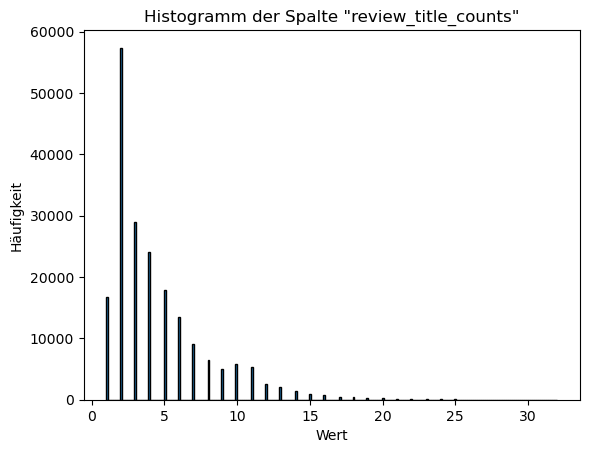

In [15]:
plot_histogram(english_df, 'review_title_counts')

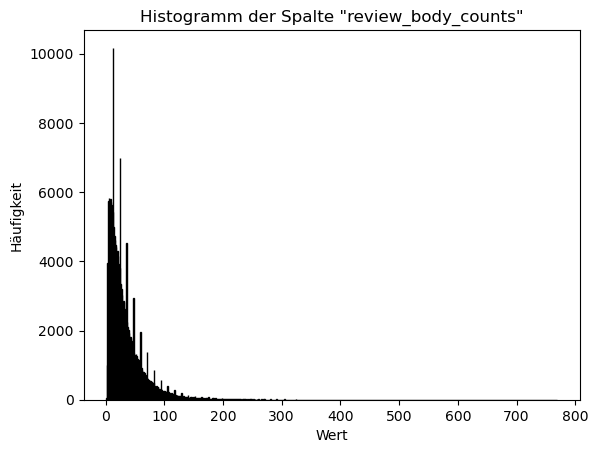

In [16]:
plot_histogram(english_df, 'review_body_counts')

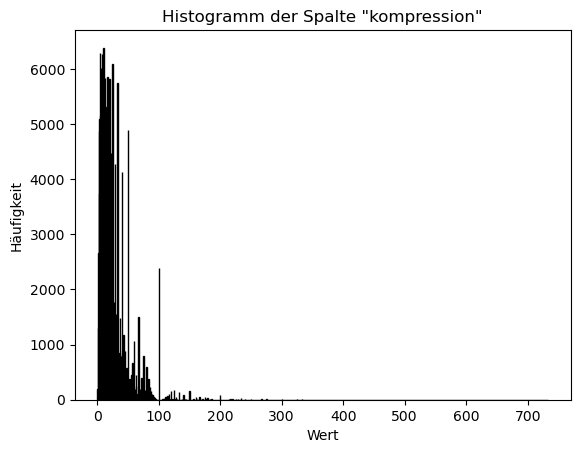

In [17]:
 plot_histogram(english_df, 'kompression')